# LeNet

### 核心思想！

```
图片 → 卷积提取特征 → 池化降低敏感性 → 全连接分类

这个思路到现在都没变！
所有CNN都是这个套路
```

---

## 二、LeNet的结构（逐层理解）

### 整体流程

```
输入(1×28×28)
    ↓
卷积层1 → 激活 → 池化层1     ← 第1组：提取简单特征
    ↓
卷积层2 → 激活 → 池化层2     ← 第2组：提取复杂特征
    ↓
拉平(Flatten)                 ← 把图片变成一维向量
    ↓
全连接层1 → 激活              ← MLP做分类
全连接层2 → 激活
全连接层3(输出层)              ← 输出10个类别
```

### 数据怎么变的（最重要）

```
输入：        1 × 28 × 28    ← 1通道，28×28的灰度图

Conv1:        6 × 28 × 28    ← 通道1→6，padding=2
Sigmoid:      6 × 28 × 28    ← 不变
AvgPool:      6 × 14 × 14    ← 通道不变，大小减半

Conv2:       16 × 10 × 10    ← 通道6→16，大小变小(没padding)
Sigmoid:     16 × 10 × 10    ← 不变
AvgPool:     16 × 5  × 5     ← 通道不变，大小减半

Flatten:     400              ← 16×5×5=400，拉成一维

Linear1:     120              ← 400→120
Linear2:     84               ← 120→84
Linear3:     10               ← 84→10（10个数字类别）
```

**规律：**

```
卷积部分：通道越来越多（1→6→16），空间越来越小（28→14→10→5）
全连接部分：逐渐压缩到类别数（400→120→84→10）
```

---

## 三、代码实现⭐⭐⭐

```python
import torch
from torch import nn

net = nn.Sequential(
    # ===== 第1组：卷积 + 激活 + 池化 =====
    nn.Conv2d(1, 6, kernel_size=5, padding=2),   # 1
    nn.Sigmoid(),                                  # 2
    nn.AvgPool2d(kernel_size=2, stride=2),         # 3
    
    # ===== 第2组：卷积 + 激活 + 池化 =====
    nn.Conv2d(6, 16, kernel_size=5),               # 4
    nn.Sigmoid(),                                   # 5
    nn.AvgPool2d(kernel_size=2, stride=2),          # 6
    
    # ===== 拉平 =====
    nn.Flatten(),                                   # 7
    
    # ===== 全连接(MLP) =====
    nn.Linear(16 * 5 * 5, 120),                    # 8
    nn.Sigmoid(),                                   # 9
    nn.Linear(120, 84),                            # 10
    nn.Sigmoid(),                                   # 11
    nn.Linear(84, 10),                             # 12
)
```

### 逐行翻译

**第1行：第一个卷积层**

```python
nn.Conv2d(1, 6, kernel_size=5, padding=2)
```

```
输入通道=1：灰度图（黑白）
输出通道=6：提取6种特征
核大小=5：5×5的窗口
padding=2：填充2圈，让输出大小不变

为什么padding=2？
    原始LeNet输入是32×32
    我们用的数据是28×28
    加padding=2让效果等价于32×32输入
    这样输出还是28×28（大小不变）
```
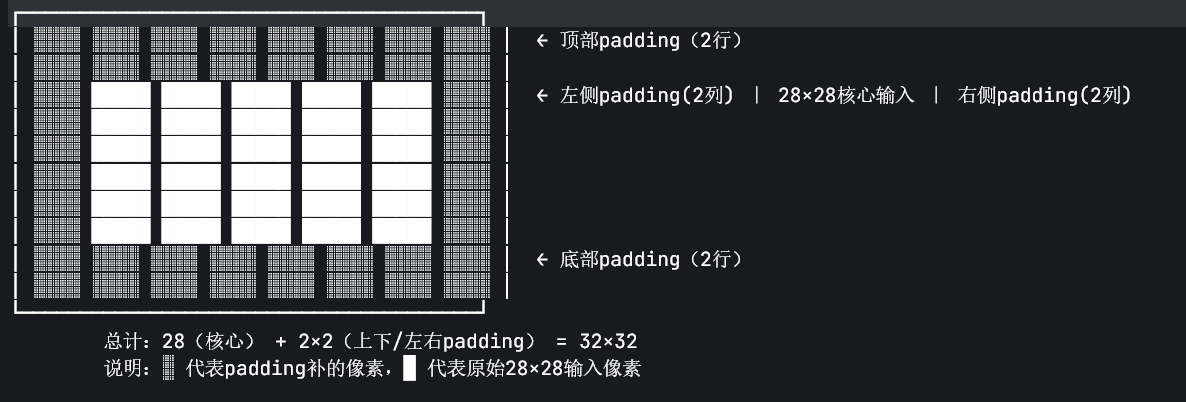

**第2行：激活函数**

```python
nn.Sigmoid()
```

```
LeNet是1989年的网络，当时还没有ReLU
现在大家都用ReLU，但这里为了还原原始设计用Sigmoid
```

**第3行：池化层**

```python
nn.AvgPool2d(kernel_size=2, stride=2)
```

```
2×2的平均池化
stride=2：窗口不重叠
效果：28×28 → 14×14（大小减半）
通道数不变：还是6
```

**第4行：第二个卷积层**

```python
nn.Conv2d(6, 16, kernel_size=5)
```

```
输入通道=6：接收上一层的6个通道
输出通道=16：提取16种更复杂的特征
核大小=5
没有padding！所以输出会变小：14-5+1=10
```

**第5-6行：和前面一样**

```
Sigmoid激活 → 池化减半
10×10 → 5×5
```

**第7行：拉平**

```python
nn.Flatten()
```

```
把4维的(批量, 16, 5, 5)变成2维的(批量, 400)
16 × 5 × 5 = 400
因为全连接层只能接收一维向量
```

**第8行：第一个全连接层**

```python
nn.Linear(16 * 5 * 5, 120)
```

```
输入：16×5×5 = 400
输出：120

为什么输入是16*5*5？
    因为拉平前最后一层的输出是 16通道 × 5高 × 5宽
    拉平后就是 16×5×5 = 400
```

**第10-12行：继续压缩**

```python
nn.Linear(120, 84)     # 120 → 84
nn.Linear(84, 10)      # 84 → 10（最终输出10个类别）
```

---

## 四、怎么检查每层的输出形状

```python
X = torch.rand(size=(1, 1, 28, 28))    # 1张图，1通道，28×28
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, '\t output shape:', X.shape)
```

```
输出：
Conv2d           output shape: torch.Size([1, 6, 28, 28])
Sigmoid          output shape: torch.Size([1, 6, 28, 28])
AvgPool2d        output shape: torch.Size([1, 6, 14, 14])
Conv2d           output shape: torch.Size([1, 16, 10, 10])
Sigmoid          output shape: torch.Size([1, 16, 10, 10])
AvgPool2d        output shape: torch.Size([1, 16, 5, 5])
Flatten          output shape: torch.Size([1, 400])
Linear           output shape: torch.Size([1, 120])
Sigmoid          output shape: torch.Size([1, 120])
Linear           output shape: torch.Size([1, 84])
Sigmoid          output shape: torch.Size([1, 84])
Linear           output shape: torch.Size([1, 10])
```

**这个技巧很实用！不确定输出形状时，跑一下就知道了。**

---

## 五、训练部分

### 你需要知道的核心改动

**和之前MLP训练的唯一区别：数据和模型要搬到GPU上**

```python
# 选设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型搬到GPU
net.to(device)

# 训练循环中，每个batch的数据也要搬到GPU
for X, y in train_loader:
    X = X.to(device)        # 数据搬到GPU
    y = y.to(device)        # 标签搬到GPU
    y_hat = net(X)           # 前向传播（在GPU上算）
    loss = loss_fn(y_hat, y) # 算损失
    loss.backward()          # 反向传播
    optimizer.step()         # 更新参数
    optimizer.zero_grad()    # 清零梯度
```

### 权重初始化

```python
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
```

```
对所有Linear层和Conv2d层用Xavier初始化
之前学过的！apply会遍历所有层
```

### 完整训练代码

```python
# 超参数
batch_size = 256
lr = 0.9
num_epochs = 10

# 数据
train_loader, test_loader = load_data_fashion_mnist(batch_size)

# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化
net.apply(init_weights)
net.to(device)

# 优化器和损失
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# 训练
for epoch in range(num_epochs):
    net.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)     # 搬到GPU
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 每个epoch结束后看看精度
    # ...（评估代码）
```

---

## 六、LeNet的设计思想（核心）

### 所有CNN都遵循的套路

```
通道数：越来越多    1 → 6 → 16 → ...
空间大小：越来越小  28 → 14 → 5 → ...
最后：拉平 + 全连接 → 输出类别数
```

**为什么这么设计？**

```
浅层：检测简单特征（边缘、纹理）→ 不需要很多通道
深层：组合复杂特征（形状、物体）→ 需要更多通道

空间变小：因为越往上看的范围越大
通道变多：因为越往上特征种类越多

就像：
    看字：先看笔画（少数几种）→ 再看部首 → 再看整个字（种类很多）
    空间越来越聚焦，但种类越来越多
```

---

## 七、关键要点

### nn.Flatten()

```python
nn.Flatten()
```

```
把多维数据拉成一维
(批量, 16, 5, 5) → (批量, 400)

为什么需要？
    卷积层输出是4维的
    全连接层只能接收2维的(批量, 特征数)
    Flatten就是中间的桥梁
```

### Linear层的输入大小怎么算？

```python
nn.Linear(16 * 5 * 5, 120)
#         ^^^^^^^^^^
#         这个数怎么来的？

# 就是Flatten前最后一层的输出：通道数 × 高 × 宽
# 16 × 5 × 5 = 400

# 不确定的话，用打印shape的方法：
X = torch.rand(1, 1, 28, 28)
for layer in net[:7]:       # 只跑到Flatten
    X = layer(X)
print(X.shape)              # torch.Size([1, 400])
# 所以Linear的输入就是400
```

### GPU相关（只需要记这三行）

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)                     # 模型搬到GPU
X, y = X.to(device), y.to(device)  # 数据搬到GPU
```

---

## 八、总结

```
LeNet结构：
    Conv → Sigmoid → Pool → Conv → Sigmoid → Pool → Flatten → FC → FC → FC

核心思想（所有CNN都一样）：
    通道越来越多，空间越来越小，最后全连接输出

代码要点：
    1. nn.Flatten() 连接卷积和全连接
    2. Linear的输入 = 最后卷积层的 通道×高×宽
    3. 数据和模型都要.to(device)

不确定输出形状？跑一下看看：
    X = torch.rand(1, 1, 28, 28)
    for layer in net:
        X = layer(X)
        print(layer.__class__.__name__, X.shape)
```